# American Express - Default Prediction
- 카드사 고객의 채무 불이행 여부 예측

## Data
- Features
  - D_* = 연체 변수 (96개)
  - S_* = 소비 변수 (22개)
  - P_* = 지불 변수 (3개)
  - B_* = 균형 변수 (40개)
  - R_* = 위험 변수 (28개)
  - Customer_ID 포함 총 190개
<br>
- 데이터 크기
  - train : 5,531,451
  - test : 11,363,762
- target
  - 총 458,913개(명) - 고객 수와 같음, 고객의 채무 불이행 여부
  - 1 (채무 불이행) : 118,828개
  - 0 (채무 정상 이행) : 340,085개
    - 실제 American Express 데이터는 690만 고객 중 10만 명만이 채무 불이행 고객일 정도로 불균형한 데이터이다. 여기서는 모델링을 쉽게 하기 위해 데이터를 균형있게 제공해준 것.
    - 그렇기 때문에 평가지표 계산 시에는 target이 0인 데이터는 20배의 가중치를 받는다.
<br>
- 아래 feature들은 범주형 데이터이고, 그 이외는 수치형 데이터
  - ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
<br>
- 기간 (시계열 데이터) - 'S_2'
  - train : 2017-03-01 ~ 2018-03-31 (396일)
  - test : 2018-04-01 ~ 2019-10-31 (579일)

In [66]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, timedelta

## 설정

In [2]:
## 모든 열을 출력한다.
pd.set_option('display.max_columns', None) 

In [3]:
DATA_DIR = './data'

## 데이터 불러와서 pickle로 저장

In [85]:
# df_train = pd.read_csv(os.path.join(DATA_DIR, 'train_data.csv'))
# df_test = pd.read_csv(os.path.join(DATA_DIR, 'test_data.csv'))
# df_train_target = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))

In [87]:
# # save pickle

# with open("./pickles/df_train.pickle", "wb") as fw:
#     pickle.dump(df_train, fw)
# with open("./pickles/df_test.pickle", "wb") as fw:
#     pickle.dump(df_test, fw)
# with open("./pickles/df_train_target.pickle", "wb") as fw:
#     pickle.dump(df_train_target, fw)

## Load pickle

In [88]:
# load pickle

with open("./pickles/df_train.pickle", "rb") as fr:
    df_train = pickle.load(fr)
with open("./pickles/df_test.pickle", "rb") as fr:
    df_test = pickle.load(fr)
with open("./pickles/df_train_target.pickle", "rb") as fr:
    df_train_target = pickle.load(fr)

- target value

In [94]:
target1 = len(df_train_target[df_train_target["target"] == 1])
target0 = len(df_train_target[df_train_target["target"] == 0])

print(f"1 (채무 불이행) : {target1}")
print(f"0 (채무 정상 이행) : {target0}")

1 (채무 불이행) : 118828
0 (채무 정상 이행) : 340085


- df_train

In [16]:
df_train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,NaN,NaN,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,NaN,0.063902,0.059416,0.006466,0.148698,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.152025,0.118075,0.001882,0.158612,0.065728,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,CR,O,0.007126,0.007665,NaN,0.652984,0.008520,NaN,0.004730,6.0,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,NaN,0.007554,0.080422,0.069067,NaN,0.004327,0.007562,NaN,0.007729,0.000272,0.001576,0.004239,0.001434,NaN,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.506612,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,NaN,0.0,0.005720,0.007084,NaN,0.000198,0.008907,NaN,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.893734,NaN,0.670041,0.009968,0.004572,NaN,1.008949,2.0,NaN,0.004326,NaN,NaN,NaN,1.007336,0.210060,0.676922,0.007871,1.0,0.238250,0.0,4.0,0.232120,0.236266,0.0,0.702280,0.434345,0.003057,0.686516,0.008740,1.0,1.003319,1.007819,1.000080,0.006805,NaN,0.002052,0.005972,NaN,0.004345,0.001535,NaN,NaN,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,NaN,NaN,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,NaN,0.065261,0.057744,0.001614,0.149723,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.156201,0.118737,0.001610,0.148459,0.093935,0.013035,0.065501,0.151387,0.265026,0.017688,0.406326,0.086805,CR,O,0.002413,0.007148,NaN,0.647093,0.002238,NaN,0.003879,6.0,0.188970,0.004030,0.509048,0.004193,0.007842,0.001283,0.006524,0.140611,0.000094,0.101018,0.040469,NaN,0.004832,0.081413,0.074166,NaN,0.004203,0.005304,NaN,0.001864,0.000979,0.009896,0.007597,0.000509,NaN,0.009810,0.000127,0.005966,0.000395,0.001327,0.007773,0.500855,0.000760,1.009461,0.081843,0.000347,0.007789,0.004311,0.002332,0.009469,0.003753,NaN,0.0,0.007584,0.006677,NaN,0.001142,0.005907,NaN,1,0.008427,0.008979,0.001854,0.009924,0.005987,0.002247,1.006779,0.002508,0.006827,0.002837,1.503577,1.005791,0.000571,0.000391,0.008351,0.008850,0.003180,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.906841,NaN,0.668647,0.003921,0.004654,NaN,1.003205,2.0,NaN,0.008707,NaN,NaN,NaN,1.007653,0.184093,0.822281,0.003444,1.0,0.247217,0.0,4.0,0.243532,0.241885,0.0,0.707017,0.430501,0.001306,0.686414,0.000755,1.0,1.008394,1.004333,1.008344,0.004407,NaN,0.001034,0.004838,NaN,0.

In [90]:
df_train["customer_ID"].nunique()

458913

- 'S_2'는 datetime으로 받아오기

In [58]:
df_train['S_2'] = pd.to_datetime(df_train['S_2'])
df_train['S_2'] = pd.to_datetime(df_test['S_2'])

- train, test의 shape

In [18]:
df_train.shape

(5531451, 190)

In [19]:
df_test.shape

(11363762, 190)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float64(185), int64(1), object(4)
memory usage: 7.8+ GB


<AxesSubplot:>

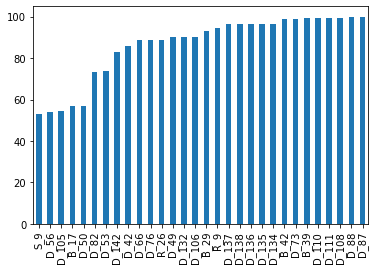

In [22]:
train_feat_null = df_train.isnull().sum() / len(df_train) * 100
train_feat_null[train_feat_null.values > 50].sort_values().plot.bar()

- categorical features

In [23]:
df_train[['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']].head()

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
1,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
2,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
3,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
4,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0


In [24]:
categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for feature in categorical:
  print(f"{feature} : {df_train[feature].unique()}")

B_30 : [ 0.  2.  1. nan]
B_38 : [ 2.  1.  3.  5.  6.  7.  4. nan]
D_114 : [ 1.  0. nan]
D_116 : [ 0. nan  1.]
D_117 : [ 4. -1.  6.  2.  1. nan  3.  5.]
D_120 : [ 0.  1. nan]
D_126 : [ 1. nan  0. -1.]
D_63 : ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
D_64 : ['O' 'R' nan 'U' '-1']
D_66 : [nan  1.  0.]
D_68 : [ 6.  2.  3. nan  5.  4.  0.  1.]
